In [22]:
import matplotlib.pyplot as plt
import numpy as np
from math import log10, inf

In [60]:
def print_matrix(matrix, headers: list[str] | None=None):
    # determine largest number
    largest_num = -inf
    for row in matrix:
        if max(row) > largest_num:
            largest_num = max(row)

    if headers is not None:
        largest_header = max([len(hdr) for hdr in headers])
    else:
        largest_header = 0

    num_length = max(len(str(largest_num)), largest_header)

    if headers is not None:
        for hdr in headers:
            print(hdr.rjust(num_length + 1, " "), end='')
        print()

    for row in matrix:
        for col in row:
            print(f"{col:{num_length}f} ", end='')
    
        print()

Each of the entries in the list below repersents a "document".  Look through the documents, are there any "rare" words that stand out for each document?

How would you "group" these documents together?  Which ones are related?

In [15]:
documents = [
    "the cat sat on the mat and the cat looked out the window",
    "the quick brown fox jumps over the lazy dog near the river",
    "machine learning uses algorithms to learn patterns from data",
    "tf idf and word2vec are common techniques in natural language processing",
    "python is a popular programming language for data science and web development",
    "the government proposed a new healthcare policy after long discussions",
    "the championship match was decided by a last minute goal from the striker",
    "bake the cake by mixing flour sugar eggs and butter then bake until golden",
    "astronomers discovered an exoplanet orbiting a distant star in the night sky",
    "travelers visited the old town markets enjoyed local food and sunny beaches",
    "startup founders presented an ai-powered platform to potential investors",
    "the river overflowed after heavy rains causing flooding in nearby towns"
]

Now we need to compute the term frequencies (TF) of each document.

The first thing we are going to do is get a listing of each unique word so that we can make a 2D array.  The columns will represent how many times that word shows up, the rows will represent each document.

In [18]:
unique_words = list(set(" ".join(documents).split()))
unique_words[:10] # show ten of the words here for demonstration

['discussions',
 'to',
 'word2vec',
 'potential',
 'visited',
 'jumps',
 'learning',
 'river',
 'nearby',
 'local']

In [30]:
# Generate the 2D array
term_frequencies = [[0 for _ in unique_words] for _ in documents]
print_matrix(term_frequencies, headers=unique_words)

# Remember that the rows are the documents and the cols are the words.

  discussions           to     word2vec    potential      visited        jumps     learning        river       nearby        local          fox     orbiting          sky       mixing      striker        after        night           in    investors     flooding        sugar         long   algorithms          web        until        rains          was          out       golden          are   processing         lazy       minute         over   ai-powered        brown          old       policy     founders      popular   discovered      science      enjoyed      distant         data     patterns          idf          dog      startup       looked  programming          cat         then        learn    presented      beaches        flour   healthcare          mat       python            a       window   government         from           an     platform        sunny        heavy    travelers           tf   overflowed      markets         cake          sat      natural      machine    exoplane

In [33]:
# Count the words in each document
for row, doc in enumerate(documents):
    for word in doc.split():
        col = unique_words.index(word)
        term_frequencies[row][col] += 1

print_matrix(term_frequencies, headers=unique_words)

  discussions           to     word2vec    potential      visited        jumps     learning        river       nearby        local          fox     orbiting          sky       mixing      striker        after        night           in    investors     flooding        sugar         long   algorithms          web        until        rains          was          out       golden          are   processing         lazy       minute         over   ai-powered        brown          old       policy     founders      popular   discovered      science      enjoyed      distant         data     patterns          idf          dog      startup       looked  programming          cat         then        learn    presented      beaches        flour   healthcare          mat       python            a       window   government         from           an     platform        sunny        heavy    travelers           tf   overflowed      markets         cake          sat      natural      machine    exoplane

Let's see which words are the most common across all documents.  Can you guess which one it is?

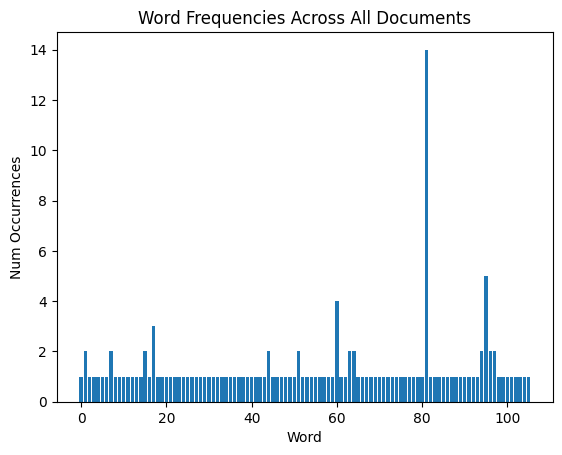

In [53]:
word_counts = [0 for _ in unique_words]
for row, doc in enumerate(documents):
    for word in doc.split():
        col = unique_words.index(word)
        word_counts[col] += 1

plt.bar(np.arange(0, len(word_counts)), word_counts, label=unique_words)
plt.title("Word Frequencies Across All Documents")
plt.xlabel("Word")
plt.ylabel("Num Occurrences")
plt.show()


Rearrange and filter to make it easier to read...

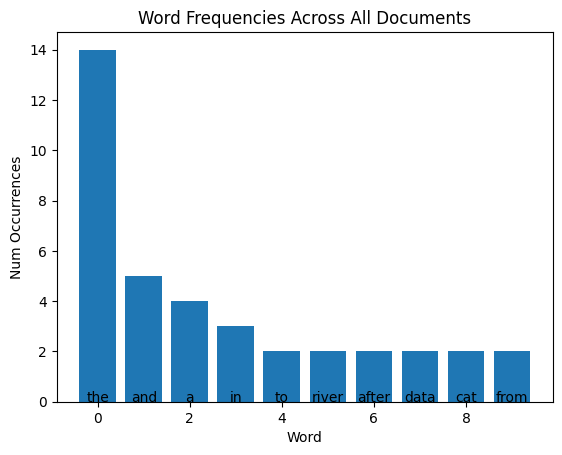

In [48]:
word_counts_dict = {unique_words[x]: word_counts[x] for x in range(len(word_counts))}
word_counts_dict = dict(sorted(word_counts_dict.items(), key=lambda item: item[1], reverse=True)[:10])


def add_labels(x, y):
    for i in range(len(x)):
        plt.text(x[i], 0, y[i], ha='center')

plt.bar(np.arange(0, len(word_counts_dict)), word_counts_dict.values(), label=word_counts_dict.keys())
plt.title("Word Frequencies Across All Documents")
plt.xlabel("Word")
plt.ylabel("Num Occurrences")
add_labels(np.arange(0, len(word_counts_dict)), list(word_counts_dict.keys()))
plt.show()

So term frequency alone is a poor indicator of a unique document!  'the' shows up a bunch of times in our documents.  Let's add the inverse-document frequency as a weight to our terms to reduce the importance of words that show up frequently.

Let's look at the log plot first.  The log grows fairly slowly over time but increases relatively quickly from `x=0` through `x=10`.  We can use that to identify terms that show up fairly frequently.

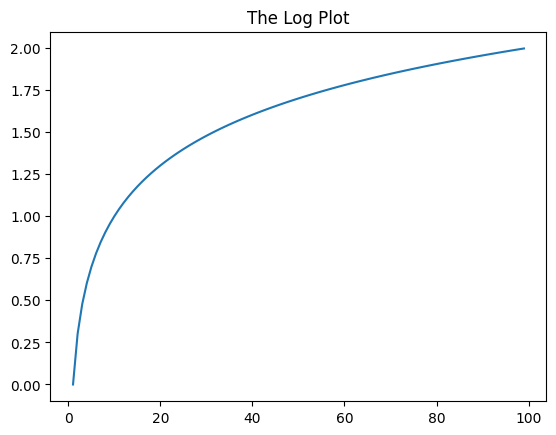

In [ ]:
xs = np.arange(1, 100)
# ys = np.arange(0, 10)
vec_log = np.vectorize(log10)
ys = vec_log(xs)
plt.plot(xs, ys)
plt.title("The Log Plot")
plt.show()

If we invert that curve (`1 / x`), we can *decrease* the value of terms that show up frequently (like 'the') and *increase* the value of terms that show up infrequently.

C:\Users\Ethan Shafer\AppData\Local\Temp\ipykernel_30156\1944678212.py:3: RuntimeWarning: divide by zero encountered in divide
  ys = 1 / vec_log(xs)


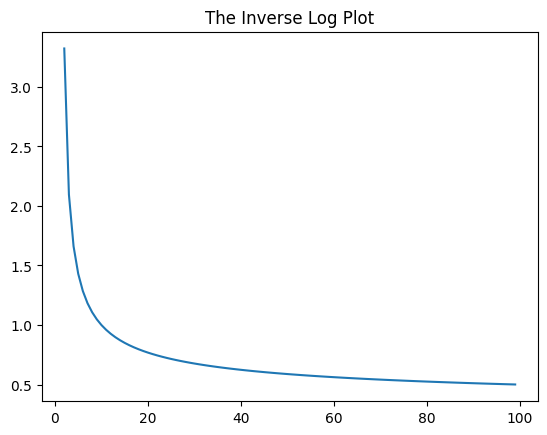

In [50]:
xs = np.arange(1, 100)
# ys = np.arange(0, 10)
ys = 1 / vec_log(xs)
plt.plot(xs, ys)
plt.title("The Inverse Log Plot")
plt.show()

# You can ignore the warning below about the div/zero error.  log(1) == 0

So you can see above that if a term shows up in less than 10 documents, it's relative weight will be increased.  If a term shows up in more than 10 documents, it's relative weight will be decreased.

Let's compute the inverse document frequency for each term.  Thankfully we already have the word counts!  The only thing we need to do is scale it down by the total number of documents.

In [56]:
inverse_doc_frequency = vec_log(len(documents) / np.array(word_counts))
# replace inf values with 0
inverse_doc_frequency

array([ 1.07918125,  0.77815125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  0.77815125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        0.77815125,  1.07918125,  0.60205999,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  0.77815125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  0.77815125,  1.07918125,  1.07918125,  1.07918125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07918125,
        0.47712125,  1.07918125,  1.07918125,  0.77815125,  0.77815125,
        1.07918125,  1.07918125,  1.07918125,  1.07918125,  1.07

Let's see how our most common words fare now.

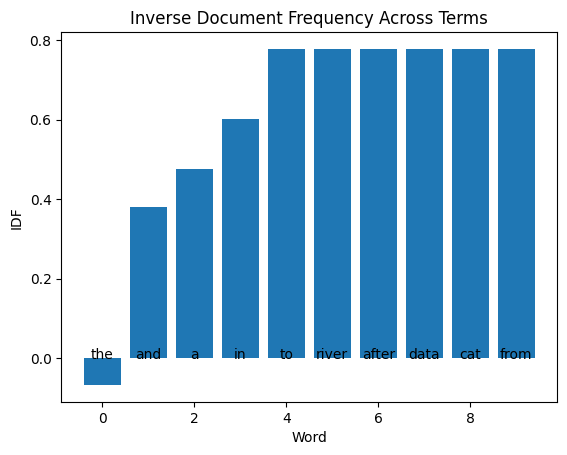

In [58]:
idf_word_counts_dict = {unique_words[x]: inverse_doc_frequency[x] for x in range(len(unique_words))}
idf_word_counts_dict = dict(sorted(idf_word_counts_dict.items(), key=lambda item: item[1])[:10])


def add_labels(x, y):
    for i in range(len(x)):
        plt.text(x[i], 0, y[i], ha='center')

plt.bar(np.arange(0, len(idf_word_counts_dict)), idf_word_counts_dict.values(), label=idf_word_counts_dict.keys())
plt.title("Inverse Document Frequency Across Terms")
plt.xlabel("Word")
plt.ylabel("IDF")
add_labels(np.arange(0, len(idf_word_counts_dict)), list(idf_word_counts_dict.keys()))
plt.show()

Computing the total TF-IDF values is then as simple as multiplying these IDF values by the term frequency for each document.

In [62]:
tf_idf = [[0 for _ in unique_words] for _ in documents]

for row, doc in enumerate(documents):
    for word in doc.split():
        col = unique_words.index(word)
        tf_idf[row][col] = term_frequencies[row][col] * inverse_doc_frequency[col]

print_matrix(tf_idf, headers=unique_words)

        discussions                 to           word2vec          potential            visited              jumps           learning              river             nearby              local                fox           orbiting                sky             mixing            striker              after              night                 in          investors           flooding              sugar               long         algorithms                web              until              rains                was                out             golden                are         processing               lazy             minute               over         ai-powered              brown                old             policy           founders            popular         discovered            science            enjoyed            distant               data           patterns                idf                dog            startup             looked        programming                cat            

If you look down the columns of the matrix, you can start to see how we might find similar documents.  For example, 'language' is associated with two documents.  Maybe they're related?

By and large this corpus of documents seems relatively independent of each other.  However, if we did a keyword search, we would likely get some good, distinct matches.

Some thoughts / exercises to do:
- Let a user enter a term that they want to search for and return documents that match their search
- Cluster documents into categories
- How could you improve this?
- Are stop words useful here or no?  What happens if we remove stop words?